# Prior Predictive Model Checking {#sec-prior-pred-mod-checking}

**Prerequisiti**

- Leggere l'articolo  *Good fit is weak evidence of replication: increasing rigor through prior predictive similarity checking* di @bonifay2024good.

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [85]:
here::here("code", "_common.R") |>
    source()

# Load packages
if (!requireNamespace("pacman")) install.packages("pacman")
pacman::p_load(
    corrplot, lavaan, semPlot, blavaan, ggdist, distributional, patchwork,
    fancycut, psych
)

## Introduzione

In questo capitolo verrà discusso l'approccio del Bayesian prior predictive similarity checking proposto da @bonifay2024good.

## Replicabilità e GOF

Il progresso scientifico empirico si basa sulla replicabilità, ossia la capacità di riprodurre i risultati di uno studio precedente seguendo le stesse procedure con nuovi dati (Bollen et al., 2015). Le ricerche sulla replicabilità in psicologia si sono spesso concentrate sugli effetti sperimentali (e.g., Klein, 2014; Open Science Collaboration, 2015; Youyou et al., 2023), ma molti ambiti della disciplina si fondano sull'uso di modelli statistici piuttosto che su un disegno sperimentale. Anche in questi contesti, è essenziale verificare il grado di replicabilità dei modelli statistici utilizzati. 

Un modo per quantificare la replicabilità dei modelli (sia nell’analisi di regressione, nei modelli a equazioni strutturali (SEM), nella teoria della risposta al item, nei modelli di rete o in altri contesti di modellizzazione) è valutare la bontà di adattamento (GOF, *goodness of fit*) del modello ai dati osservati. Storicamente, molti ricercatori in psicologia hanno considerato la replicabilità di un modello principalmente come la capacità di riprodurre la bontà di adattamento di uno studio precedente: «[il] miglior adattamento del modello... ha replicato i risultati» di ricerche precedenti (Whiteman et al., 2022, p. 132), «il miglior adattamento... ha replicato i risultati precedenti» (Giuntoli et al., 2021, p. 1668), «un adattamento sostanzialmente migliore... ha replicato l’approccio classico» (Fernández de la Cruz et al., 2018, p. 608). Tuttavia, @bonifay2024good fanno notare come questa pratica meriti un’attenta considerazione, in quanto la mera replicazione di una buona bontà di adattamento non è sufficiente per confermare la validità del modello statistico originale e della teoria sottostante.

@bonifay2024good propongono il seguente esempio. Si considerino le matrici di covarianza simulate mostrate nella riga superiore della Figura 1. La matrice a sinistra (Pannello B) rappresenta le covarianze tra le variabili di uno studio originale, mentre le altre due (Pannelli C e D) rappresentano le covarianze delle stesse variabili in due dataset di replicazione. Questo scenario illustra il tipico caso di replicazione del modello, in cui la stessa struttura viene adattata a dataset differenti, lasciando liberi i parametri. Sebbene le differenze nei dati siano evidenti, un modello con due fattori correlati si adatta bene a ciascuna matrice di covarianza (indice di adattamento comparativo [CFI] elevato, i.e., ≥ 0.95). Una bontà di adattamento elevata indica che il modello rappresenta adeguatamente le covarianze all’interno del dataset originale e delle repliche, ma non informa sul fatto che il modello rifletta le stesse relazioni tra le variabili. Come mostrato in Figura 1, affidarsi esclusivamente alla bontà di adattamento può portare a ignorare differenze significative nei pattern di dati.

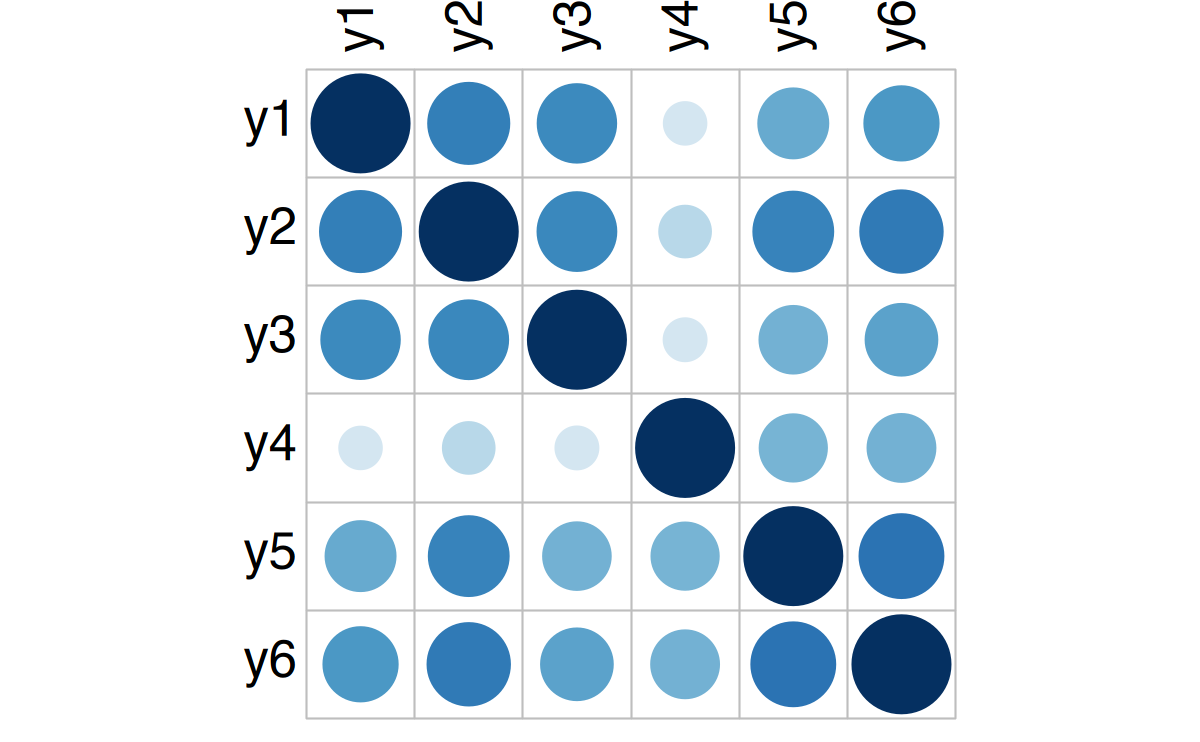

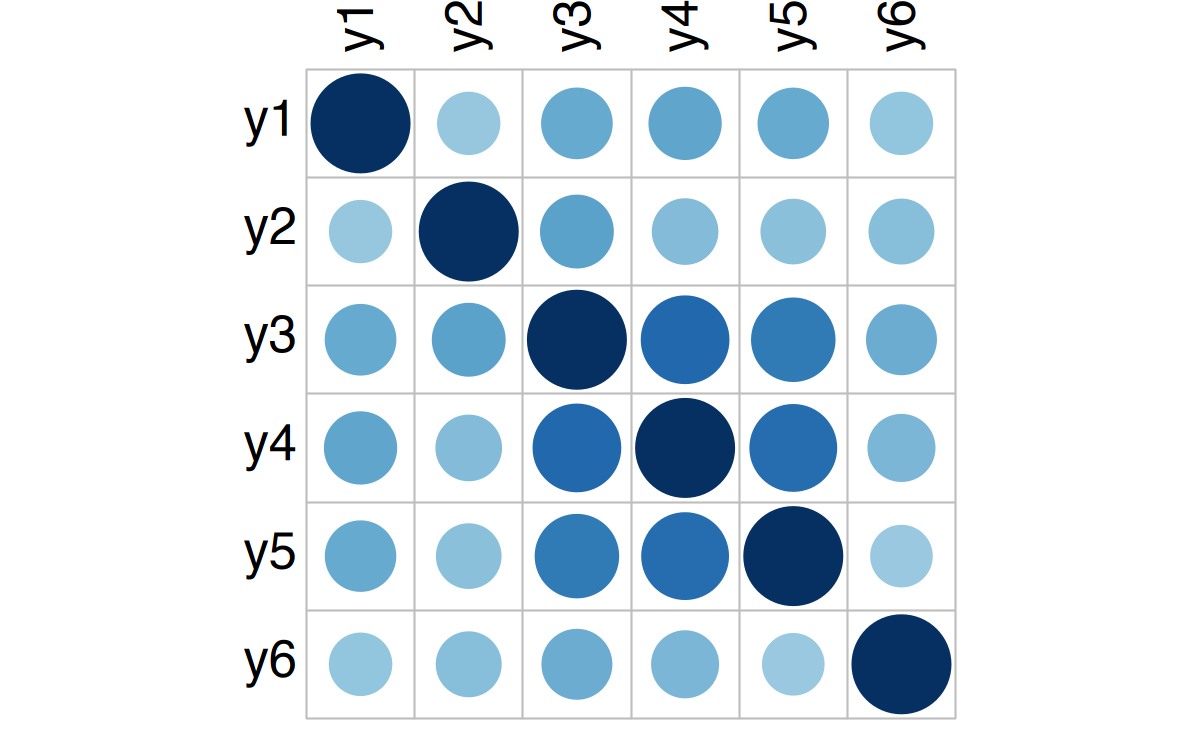

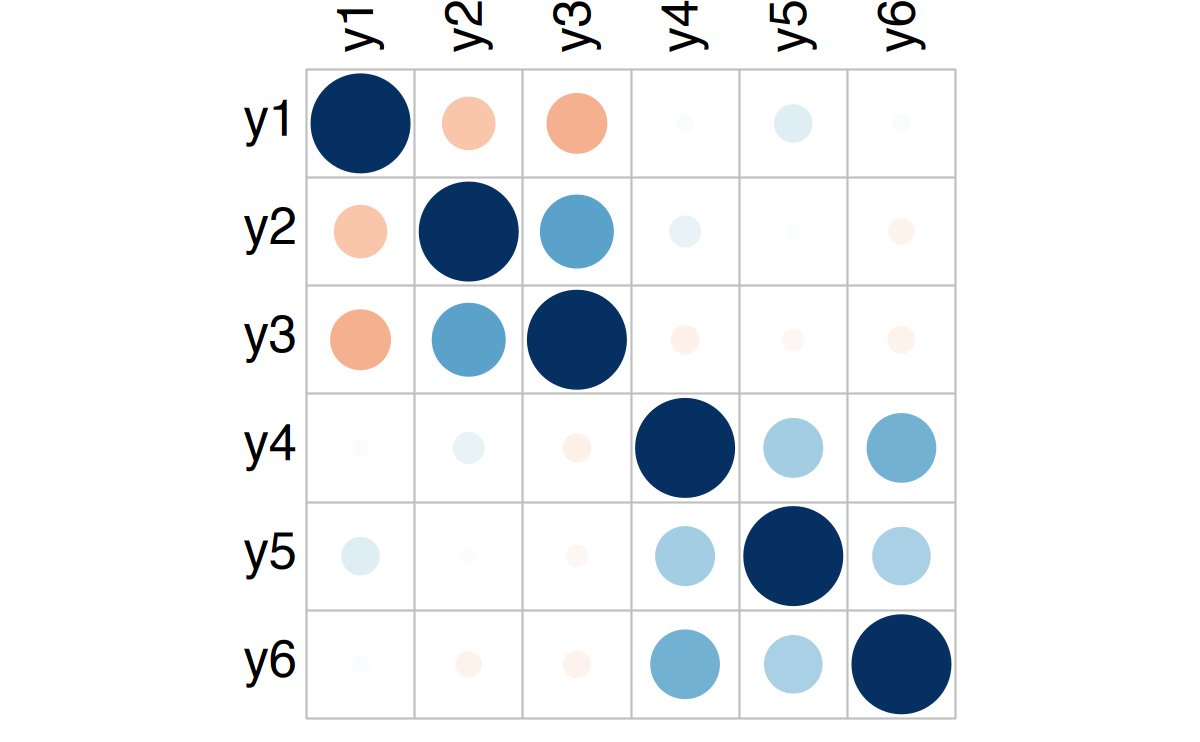

In [13]:
# Load Correlation Matrices ----
cor_mats <- readRDS(
    here::here("data", "Bonifay", "figure1_cormat.RDS")
)

# Create and Save Correlation Plots ----
corrplot(cor_mats[[1]],
    method = "circle", type = "full",
    tl.col = "black", tl.cex = 2.5, cl.pos = "n"
)

corrplot(cor_mats[[2]],
    method = "circle", type = "full",
    tl.col = "black", tl.cex = 2.5, cl.pos = "n"
)

corrplot(cor_mats[[3]],
    method = "circle", type = "full",
    tl.col = "black", tl.cex = 2.5, cl.pos = "n"
)

In [14]:
cor_mats

,y1,y2,y3,y4,y5,y6
y1,1.000,0.682,0.638,0.185,0.507,0.571
y2,0.682,1.000,0.644,0.275,0.661,0.705
y3,0.638,0.644,1.000,0.189,0.473,0.532
y4,0.185,0.275,0.189,1.000,0.468,0.477
y5,0.507,0.661,0.473,0.468,1.000,0.730
y6,0.571,0.705,0.532,0.477,0.730,1.000
,y1,y2,y3,y4,y5,y6
y1,1.000,0.389,0.503,0.527,0.501,0.391
y2,0.389,1.000,0.536,0.432,0.420,0.423
y3,0.503,0.536,1.000,0.782,0.707,0.493


In [19]:
M <- '
    F1 =~ NA*y1 + y2 + y3
    F2 =~ NA*y4 + y5 + y6
    F1 ~~ 1*F1
    F2 ~~ 1 * F2
'

fit_original <- cfa(model = M, sample.cov = cor_mats$original, sample.nobs = 1000)
parameterEstimates(fit_original)

lhs,op,rhs,est,se,z,pvalue,ci.lower,ci.upper
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F1,=~,y1,0.772,0.0278,27.73,0,0.718,0.827
F1,=~,y2,0.899,0.0260,34.56,0,0.848,0.949
F1,=~,y3,0.732,0.0284,25.77,0,0.677,0.788
F2,=~,y4,0.502,0.0311,16.11,0,0.441,0.563
F2,=~,y5,0.823,0.0272,30.22,0,0.770,0.876
F2,=~,y6,0.903,0.0262,34.53,0,0.852,0.954
F1,~~,F1,1.000,0.0000,NA,NA,1.000,1.000
F2,~~,F2,1.000,0.0000,NA,NA,1.000,1.000
y1,~~,y1,0.403,0.0224,18.00,0,0.359,0.447


In [22]:
fitMeasures(fit_original, "cfi") |> round(2)

cfi 
0.96

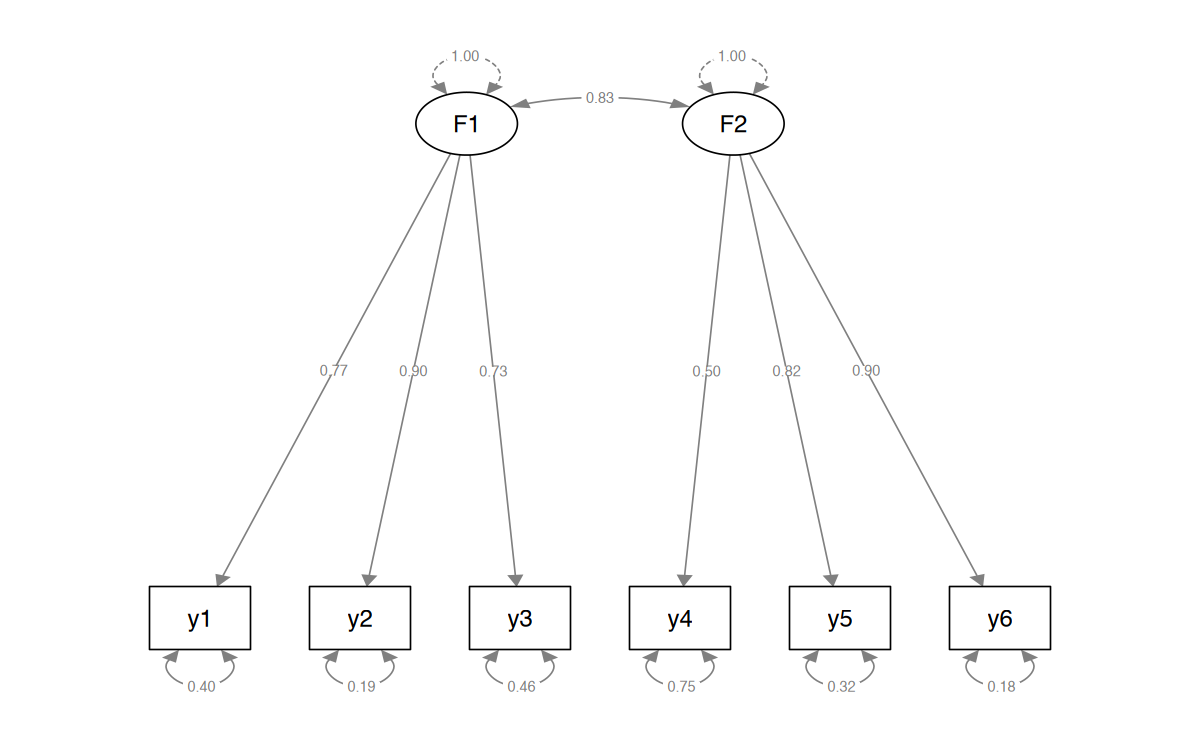

In [30]:
semPaths(fit_original,
    whatLabels = "std",
    sizeMan = 8,
    edge.label.cex = 0.7,
    style = "mx",
    nCharNodes = 0, nCharEdges = 0
)

In [23]:
fit_rep1 <- cfa(model = M, sample.cov = cor_mats$replication1, sample.nobs = 1000)
parameterEstimates(fit_rep1)

lhs,op,rhs,est,se,z,pvalue,ci.lower,ci.upper
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F1,=~,y1,0.596,0.0300,19.88,0,0.537,0.655
F1,=~,y2,0.566,0.0303,18.69,0,0.507,0.626
F1,=~,y3,0.899,0.0265,33.95,0,0.847,0.951
F2,=~,y4,0.904,0.0254,35.67,0,0.855,0.954
F2,=~,y5,0.830,0.0265,31.34,0,0.778,0.882
F2,=~,y6,0.524,0.0306,17.14,0,0.464,0.584
F1,~~,F1,1.000,0.0000,NA,NA,1.000,1.000
F2,~~,F2,1.000,0.0000,NA,NA,1.000,1.000
y1,~~,y1,0.644,0.0306,21.02,0,0.584,0.704


In [24]:
fitMeasures(fit_rep1, "cfi") |> round(2)

cfi 
0.96

In [25]:
fit_rep2 <- cfa(model = M, sample.cov = cor_mats$replication2, sample.nobs = 1000)
parameterEstimates(fit_rep2)

lhs,op,rhs,est,se,z,pvalue,ci.lower,ci.upper
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F1,=~,y1,0.422,0.0363,11.62,0.000000,0.35098,0.493
F1,=~,y2,-0.627,0.0412,-15.23,0.000000,-0.70783,-0.546
F1,=~,y3,-0.855,0.0479,-17.86,0.000000,-0.94899,-0.761
F2,=~,y4,0.701,0.0418,16.78,0.000000,0.61899,0.783
F2,=~,y5,0.491,0.0370,13.26,0.000000,0.41836,0.563
F2,=~,y6,0.676,0.0411,16.43,0.000000,0.59526,0.757
F1,~~,F1,1.000,0.0000,NA,NA,1.00000,1.000
F2,~~,F2,1.000,0.0000,NA,NA,1.00000,1.000
y1,~~,y1,0.821,0.0405,20.27,0.000000,0.74139,0.900


In [26]:
fitMeasures(fit_rep2, "cfi") |> round(2)

cfi 
0.94

A complicare ulteriormente le cose, l’adattamento dello stesso modello a ciascuna matrice di dati produce stime dei parametri molto variabili. Ad esempio, il fattore di carico standardizzato l21 (secondo indicatore sul primo fattore) è stimato a 0.90, 0.57 e -2.63 nelle tre matrici, mentre la correlazione tra i fattori (c21) varia da quasi indipendenza (0.09) a una sovrapposizione quasi totale (0.96). 

In sintesi, la bontà di adattamento non ci fornisce alcuna indicazione sul grado di somiglianza tra il dataset di replicazione, i parametri del modello e quelli dello studio originale, mentre una forte somiglianza tra questi elementi è cruciale per valutare il successo della replicazione.

## Bontà di Adattamento e Replicazione

Nel loro approfondimento critico sull’uso della bontà di adattamento come strumento per testare le teorie, @roberts2000persuasive hanno sostenuto che «dimostrare che una teoria si adatta ai dati... è quasi privo di significato» (p. 361; vedi anche Vanpaemel, 2020). In particolare, hanno individuato tre limiti del GOF che ne impediscono l’uso come supporto teorico solido:

1. Non chiarisce cosa predice una teoria.  
2. Non spiega la variabilità dei dati.  
3. Non considera la probabilità a priori che la teoria possa adattarsi a qualsiasi insieme di dati plausibili.

Di conseguenza, @roberts2000persuasive hanno concluso che il GOF fornisce un supporto convincente a una teoria solo quando sia i dati che la teoria sono ben vincolati, ovvero quando i dati non sono troppo variabili e la teoria non è troppo flessibile. Tuttavia, in un singolo studio, tali vincoli possono essere difficili da definire e applicare, anche per la mancanza di criteri di riferimento (ad esempio, cosa significa dire che i dati «non sono troppo variabili»? Variabili rispetto a cosa? E in che misura?).

Nel contesto delle repliche, però, il confronto con lo studio originale offre un chiaro riferimento per caratterizzare la variabilità dei dati e delle stime dei parametri del modello. Questo consente di estendere naturalmente le tre critiche di @roberts2000persuasive al tema della replicazione:

1. **Previsione limitata del risultato della replica**  
   La bontà di adattamento dello studio originale non fornisce alcuna informazione sostanziale sull’esito della replica. Il fatto che un modello si sia adattato bene nello studio originale non implica che si replichino aspetti inferenziali più importanti, come i pattern dei dati o le stime dei parametri.

2. **Assenza di indicazioni sulla somiglianza tra i dati originali e quelli della replica**  
   Due set di dati possono presentare pattern nettamente distinti, potenzialmente derivanti da meccanismi di generazione diversi. Tuttavia, il modello potrebbe mascherare queste differenze, compromettendo l’accuratezza delle inferenze.

3. **Tendenza intrinseca del modello ad adattarsi bene**  
   Se un modello possiede una forte predisposizione ad adattarsi bene ai dati (Bonifay & Cai, 2017; Falk & Muthukrishna, 2023), una buona bontà di adattamento per i dati originali e di replica non rappresenta una sorpresa né un valore scientifico. In tali casi, il GOF può replicarsi indipendentemente dai pattern specifici dei dati che il modello intende rappresentare.

Idealmente, i ricercatori possono essere fiduciosi che i loro risultati offrano un supporto alla teoria alla base del modello statistico solo se dimostrano che i dati della replica non sono più variabili rispetto ai dati originali, e che le stime dei parametri nella replica non riflettono una maggiore flessibilità rispetto a quelle originali.

## Definire l’Obiettivo della Replica

In psicologia, ottenere una somiglianza perfetta tra studi è poco pratico e probabilmente non necessario, anche a causa dell’eterogeneità intrinseca della popolazione (McShane et al., 2019). Piuttosto, i ricercatori dovrebbero focalizzarsi sugli aspetti specifici dello studio originale che intendono replicare. A tal proposito, la Figura 2 illustra un approccio più ragionevole per definire obiettivi di replicazione. 

::: {#fig-bonifay}
![](../../figures/bonifay_fig2.pdf){width="50%"}

Definire Obiettivi Chiari è Essenziale per Indagare la Replicazione dei Modelli Statistici. *Nota*: Per andare oltre la semplice replicazione della bontà di adattamento (*Goodness of Fit*), i ricercatori devono mirare alle aree più significative e centrali del bersaglio. Questo richiede test più rigorosi dei dati e/o dei parametri del modello, che possono essere condotti utilizzando tecniche bayesiane di verifica della similarità predittiva a priori, con l’impiego di distribuzioni a priori sempre più informative, come illustrato nella parte inferiore della figura. La replicazione informata dalla teoria richiede, come minimo, di verificare ipotesi specifiche sui dati e/o sui parametri del modello. La replicazione empirica, sia approssimativa che ravvicinata, implica invece il controllo che i dati replicati e/o i parametri del modello siano rispettivamente approssimativamente o strettamente simili a quelli dello studio originale. [Figura tratta da @bonifay2024good]
:::

- **Cerchio esterno del bersaglio**: rappresenta la pratica attuale nelle scienze sociali, spesso limitata a verificare che il modello originale abbia una buona bontà di adattamento ai dati della replica, senza considerare le caratteristiche empiriche dello studio originale. Questa pratica offre il supporto più debole alla teoria originale.  

- **Cerchi interni**: rappresentano obiettivi progressivamente più ambiziosi. 

### Obiettivi di replica:

1. **Replicazione informata dalla teoria**: un ricercatore interessato alle implicazioni teoriche più ampie dello studio originale può puntare alla teoria sottostante, formulando ipotesi specifiche sui dati o sulle stime dei parametri (es. "Per supportare l’associazione positiva tra x e y, il coefficiente di replica b deve avere un valore positivo"). Questo approccio supera la semplice verifica del GOF e merita studi dedicati.

2. **Replicazione empirica approssimativa**: un ricercatore che desidera replicare direttamente i risultati empirici può puntare allo studio originale, testando la somiglianza approssimativa tra i dati e il modello della replica rispetto a quelli originali. Ad esempio, si può verificare se le covarianze tra i dati di replica riflettono quelle dello studio originale o se le stime dei parametri sono simili (es. "Per una replica approssimativa, b1 deve essere tra 0.4 e 0.7").

3. **Replicazione empirica ravvicinata**: è il test più rigoroso, in cui le stime devono essere estremamente simili a quelle originali (es. "Per una replica ravvicinata, b1 deve essere tra 0.52 e 0.58"). Riuscire a soddisfare tali criteri fornisce prove solide che il modello cattura lo stesso segnale in entrambi gli studi.

### Test progressivi e rischiosi

La struttura a cerchi concentrici del bersaglio rappresenta una sequenza di test sempre più stringenti. Come osservato da @roberts2000persuasive, i test di bontà di adattamento sono spesso troppo facili da superare, rendendoli deboli come prova di replica. La replicazione basata sul GOF è l’obiettivo più facile (e per alcuni modelli può comportare un rischio di fallimento praticamente nullo), offrendo il supporto più debole ai risultati originali.

- **Cerchi interni del bersaglio**: man mano che ci si avvicina al centro, il rischio di fallimento aumenta, ma aumenta anche la forza delle prove a favore della replica. La replicazione informata dalla teoria è più rigorosa rispetto al GOF, offrendo supporto alla teoria sottostante. La replicazione empirica approssimativa è ancora più rischiosa, ma fornisce prove solide di somiglianza tra dati e parametri. Infine, la replicazione empirica ravvicinata è il test più rischioso, ma il suo successo rappresenta una prova molto forte della replica dei risultati originali.

Come sottolineato da @waller2002risky, «i test rischiosi sono i mezzi più efficienti per valutare la solidità di una teoria».

Nella seconda parte dell'articolo, @bonifay2024good presentano un metodo statistico per quantificare la somiglianza tra i dati originali e replicati, oltre che tra le stime dei parametri. Discutono un esempio concreto nel contesto della modellizzazione della struttura latente della psicopatologia e forniscono raccomandazioni per futuri studi di replicazione. 

## Verifica Predittiva a Priori dei Modelli

Per indagare formalmente la somiglianza tra dati originali e di replica, nonché tra le stime dei parametri, @bonifay2024good propongono di utilizzare la verifica predittiva a priori bayesiana (*Prior Predictive Model Checking*, PrPMC; Box, 1980; Evans & Moshonov, 2006; Gelman et al., 2017). Questa tecnica sfrutta le distribuzioni a priori per valutare le implicazioni del modello prima di includere i dati osservati nell’analisi.

In un'analisi bayesiana, l’obiettivo principale è calcolare la distribuzione a posteriori $p(\theta \mid y)$, combinando le informazioni sui dati osservati $y$ e sul parametro sconosciuto $\theta$ tramite il teorema di Bayes:

$$
p(\theta \mid y) \propto p(y \mid \theta)p(\theta),
$$

dove:

- $p(\theta)$ è la distribuzione a priori dei parametri.
- $p(y \mid \theta)$ è la funzione di verosimiglianza dei dati dato il modello.

La PrPMC consiste nel generare campioni predittivi ipotetici per ciascuna variabile osservata, utilizzando esclusivamente le distribuzioni a priori definite sui parametri del modello. Questi campioni rappresentano scenari plausibili in base alle aspettative incorporate nei priori, permettendo una valutazione preliminare del modello.

Supponiamo di voler stimare l’altezza media degli scalatori negli Stati Uniti, ipotizzando che sia vicina alla media nazionale di 168 cm (Fryar et al., 2021). Possiamo rappresentare questa aspettativa con una distribuzione normale $N(\mu = 168, \sigma = 10)$. Generando campioni predittivi da questa distribuzione, otteniamo valori che variano plausibilmente attorno a questa media. Se la conoscenza sugli scalatori suggerisse un valore maggiore o minore, potremmo affinare i priori (ad esempio, aumentando $\mu$ o riducendo $\sigma$) prima di raccogliere i dati.

La PrPMC può essere estesa per confrontare i dati osservati con i campioni predittivi. Questo confronto utilizza una statistica di test o una quantità di test per valutare la somiglianza tra i dati osservati e le aspettative predittive. 

- **Statistica di test**: una proprietà statistica dei dati (es. mediana, range).
- **Quantità di test**: una proprietà dipendente dai dati e dal modello (es. stime dei parametri o indici di bontà di adattamento).

Ad esempio, per gli scalatori, potremmo confrontare la media delle altezze osservate con le medie dei campioni predittivi. Se la media osservata si trovasse agli estremi della distribuzione predittiva (ad esempio, $prpp \leq 0.05$ o $prpp \geq 0.95$), ciò indicherebbe una discrepanza sistematica tra i dati osservati e le aspettative a priori.

@bonifay2024good propongono l’uso della PrPMC per verificare la somiglianza tra dati originali e di replica, così come tra le stime dei parametri del modello. Questo approccio, chiamato *verifica di similarità predittiva a priori*, consente di valutare:

1. **Somiglianza dei dati**: confrontando la distribuzione dei dati replicati con le aspettative dei dati originali (es. intercorrelazioni tra item).
2. **Somiglianza dei parametri**: confrontando le stime dei parametri derivanti dai dati di replica con quelle predette dal modello originale. Ad esempio, i caricamenti fattoriali stimati dal modello originale possono essere confrontati con quelli derivati da campioni predittivi a priori.

Come illustrato nella @fig-bonifay, i cerchi concentrici rappresentano diversi livelli di rischio e severità nei test di replica:

- **Cerchio esterno**: distribuzioni a priori diffuse, che riflettono una bassa restrizione sui dati e sui parametri, portando a test meno rigorosi e meno significativi.
- **Centro del bersaglio**: distribuzioni a priori altamente informative, con restrizioni strette sui dati e sui parametri, producendo test più rigorosi e significativi.

Se il valore $prpp$ risultante si trova tra $0.05$ e $0.95$, possiamo concludere che i dati e/o i parametri replicati sono coerenti con le aspettative a priori. Questo approccio consente di condurre test progressivamente più stringenti e di acquisire prove più solide del successo della replica.

## Riflessioni Conclusive

In conclusione, la verifica predittiva a priori offre un metodo formale per quantificare la somiglianza tra studi originali e repliche, sia a livello di dati che di parametri. Implementando questa metodologia, i ricercatori possono definire obiettivi chiari e condurre analisi rigorose per valutare il successo della replicazione, migliorando così la robustezza delle conclusioni dello studio.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [27]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: aarch64-apple-darwin20
Running under: macOS Sequoia 15.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

Random number generation:
 RNG:     L'Ecuyer-CMRG 
 Normal:  Inversion 
 Sample:  Rejection 
 
locale:
[1] C

time zone: Europe/Rome
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] quantreg_5.99     compute.es_0.2-5  simsem_0.5-16     kableExtra_1.4.0 
 [5] MASS_7.3-61       viridis_0.6.5     viridisLite_0.4.2 ggpubr_0.6.0     
 [9] ggExtra_0.10.1    gridExtra_2.3     patchwork_1.3.0   bayesplot_1.11.1 
[13] semTools_0.5-6    semPlot_1.1.6     lavaan_0.6-19     psych_2.4.6.26   
[17] scales_1.3.0      markdown_1.13     knitr_1.49        lubridate_1.9.3  
[21] 